<p>
<b>ADNI notebook</b><br>
Jesse Brown<br>
jesse.brown@ucsf.edu

<p>
IMPORTANT NOTE: Before you can work with this data, you must apply to access the data here:
https://ida.loni.usc.edu/collaboration/access/appApply.jsp?project=ADNI
which requires you to accept all terms of the ADNI data use agreement (shown here):
http://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf
Note this term in particular: "I will require anyone on my team who utilizes these data, or anyone with whom I share these data to comply with this data use agreement."

This data is MRI images from the Alzheimer's Disease Neuroimaging Initiative (http://adni.loni.usc.edu/). The data compiled here are: 3013 T1-weighted structural MRI scans from 321 subjects (112 of whom are cognitively normal at at least one timepoint, 129 mild cognitive impairment, 150 Alzheimer's disease) demographic data: clinical diagnosis, age, sex

This set was created as part of the Deep Learning Part 1 course at USF. One goal is to build an accurate classifier of individual brain images into one of three classes - Clinically Normal (CN), Mild Cognitive Impairment (MCI), or Alzheimer's Disease (AD) - probably using a convolutional neural network since that's a focus of the course. Related goals are to 1) assess whether accurate classification is possible using only single brain slices or if information from all slices from a given brain need to be aggregated, and 2) be able to visualize the "salient" voxels of the brain image that the classifier uses to discriminate, following this excellent demonstration: https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb

Additional post-processing I've done:
- skull stripping to remove non-brain voxels
- realignment of each scan to standard space coordinates with 2mm isotropic resolution (linear affine transform)
- separation of the 3D images into 91 2D axial slices
- exclusion of 2D slices at the extreme ends the z-axis where there is no or very little brain (keeping 62/91 slices)
- padding/trimming images to obtain 96x96 square images
- splitting of images into train, validation, and test sets; some subjects have scans in multiple sets, some subjects are only represented in one set

There are 3013 scans from 321 subjects (130758 96x96 2D images for training, 26970 for validation, 29078 for test), who are about an equal balance of cognitively normal, mild cognitive impairment, and Alzheimer's disease. Across these 321 subjects, there are 1319 total longitudinal timepoints, where some subjects have 2 only timepoints, some have 3, some have 4+. The remaining 1694 (3013 - 1319) scans are repeat scans of subjects later on the same day. These are included so that we can assess the reliability of different scans on the same day, accounting for MRI scanner noise that is unique for each scan run. The subjects are a mixture of those with a consistent diagnosis across all longitudinal timepoints and those whose diagnosis changes, from CN-> MCI, MCI->AD, or even reversion of AD->MCI, MCI->CN in some cases. The scans are saved in zipped numpy .npy array arrays and the metadata for each scan is in the adni_demographic_master_kaggle.csv. The images are flattened into 1x9216 1D vectors. Below are instructions for reassembling the full training/validation/test set of images (130758 x 9216, 26970x9216, 29078x9216). The first 62 rows in the training data come from training subject 1 in the adni_demographic_master_kaggle.csv, the next 62 training rows come from training subject 2, and so forth.

It is very likely that certain 2D images/slices contain much more diagnostic information about CN vs MCI vs AD, for example those slices which contain the hippocampus, while slices from very low or high in the brain may not contain enough information to accurately classify. The reason for attempting to classify 2D slices rather than whole 3D scans is that often individuals often receive clinical scans that do not cover the entire brain, only imaging intermittent slices to save time and money.

In [1]:
import numpy as np
import scipy
import scipy.spatial
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import keras
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Deconvolution2D, UpSampling2D, Reshape, Flatten, ZeroPadding2D, BatchNormalization, Lambda, Dropout
from keras.models import Model, Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
# load the image data and classification labels
pth = '/home/ubuntu/search/'

load_kaggle = False

if load_kaggle: # option 1: load data in chunks as it comes from kaggle
    trX = np.load('img_array_train_6k_1.npy')
    for i in range(2,23):
        train_cur = np.load('img_array_train_6k_%d.npy' %i)
        trX = np.vstack((trX, train_cur))
    vaX = np.load('img_array_valid_6k_1.npy')
    for i in range(2,6):
        valid_cur = np.load('img_array_valid_6k_%d.npy' %i)
        vaX = np.vstack((vaX, valid_cur))
    teX = np.load('img_array_test_6k_1.npy')
    for i in range(2,6):
        test_cur = np.load('img_array_test_6k_%d.npy' %i)
        teX = np.vstack((teX, test_cur))
else: # option 2: load pre-saved full data matrices
    trX = np.load(pth + 'img_array_130758_96_96.npy')
    trX = np.expand_dims(trX,axis=1)
    vaX = np.load(pth + 'img_array_26970_96_96.npy')
    vaX = np.expand_dims(vaX,axis=1)
    #teX = np.load(pth + 'img_array_29078_96_96.npy')
    #teX = np.expand_dims(teX,axis=1)

In [4]:
# normalize the images on a per-image basis
imgwise_scaling = True
if imgwise_scaling:
    for n in range(len(trX)):
        trX[n,:,:,:] = trX[n,:,:,:] - np.mean(trX[n,:,:,:].flatten())
        trX[n,:,:,:] = trX[n,:,:,:] / np.std(trX[n,:,:,:].flatten())
    for n in range(len(vaX)):
        vaX[n,:,:,:] = vaX[n,:,:,:] - np.mean(vaX[n,:,:,:].flatten())
        vaX[n,:,:,:] = vaX[n,:,:,:] / np.std(vaX[n,:,:,:].flatten())
    #for n in range(len(teX)):
    #    teX[n,:,:,:] = teX[n,:,:,:] - np.mean(teX[n,:,:,:].flatten())
    #    teX[n,:,:,:] = teX[n,:,:,:] / np.std(teX[n,:,:,:].flatten())

In [5]:
# read in subject info + demographics
# each scan has 62 2D images
# diagnosis: 1=Cognitively Normal, 2=Mild Cognitive Impairment, 3=Alzheimer's Disease
# train_valid_test: 0=train, 1=validation, 2=test (based on my criteria, 
# where some subjects only have data in one of train/valid/test, 
# some subjects have different scans in different sets)
import pandas as pd
demo = pd.read_csv(pth + 'adni_demographic_master_kaggle.csv')

In [6]:
# get diagnosis (ie class) for each scan
trX_subjs = demo[(demo['train_valid_test']==0)]
trY = np.asarray(trX_subjs.diagnosis)
vaX_subjs = demo[(demo['train_valid_test']==1)]
vaY = np.asarray(vaX_subjs.diagnosis)

trY_all = []
for n in trY:
    for i in range(62):
        trY_all.append(n)
trY_all = np.asarray(trY_all)
vaY_all = []
for n in vaY:
    for i in range(62):
        vaY_all.append(n)
vaY_all = np.asarray(vaY_all)
#teY_all = []
#for n in teY:
#    for i in range(62):
#        teY_all.append(n)
#teY_all = np.asarray(teY_all)

# onehot encode class for each image
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
trY_labels = onehot(trY_all)
vaY_labels = onehot(vaY_all)
#teY_labels = onehot(teY_all)

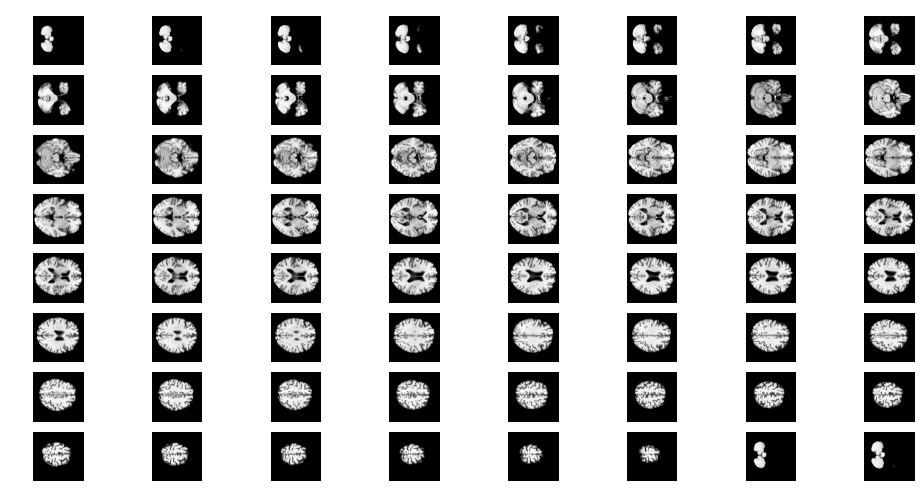

In [7]:
# display images
%matplotlib inline
# show a single image
# plt.imshow(trX[0,0,:,:],cmap=cm.Greys_r,interpolation='none')

# show all images from a given scan
n = 0
start = n*62
stop = start+64 # 64 is a hack since I was too lazy to figure out how to display 62

cur_subj = trX_subjs.iloc[[n]]

rows = 8
titles = None
ims = trX[start:stop,0,:,:]
figsize=(12,6)
f = plt.figure(figsize=figsize)
for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims)//rows, i+1)
    if titles is not None:
        sp.set_title(titles[i], fontsize=18)
    plt.imshow(ims[i], interpolation=None, cmap=cm.Greys_r)
    plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    plt.axis('off')

In [8]:
# setup convolutional network classifier
model = Sequential([
        BatchNormalization(axis=1, input_shape=(1,96,96)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(128,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

adam = Adam(lr=0.0001)
model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# name for model weights file, which can optionally be loaded
load_weights = False
model_weights_file = pth + 'adni_classifier_v1.h5'
if load_weights:
    model.load_weights(model_weights)

# fit model
model.fit(trX,trY_labels,batch_size=128,nb_epoch=1,shuffle=True,validation_data=(vaX,vaY_labels))

# if modifying learning rate
if False:
    model.optimizer.lr.set_value(0.01)

# if save model weights
if False:
    model.save_weights(model_weights_file)

Train on 130758 samples, validate on 26970 samples
Epoch 1/1
130758/130758 [==============================] - 319s - loss: 0.8632 - acc: 0.6339 - val_loss: 0.9839 - val_acc: 0.5372


In [10]:
# get all subjects in training set with AD diagnosis
AD_trX_subjs = demo[(demo['train_valid_test']==0) & (demo['diagnosis']==3)]

In [11]:
# get classifications for each validation image
np.set_printoptions(suppress=True)
p = model.predict_classes(vaX)
pp = model.predict_proba(vaX)

26970/26970 [==============================] - 20s    


In [12]:
# get predicted class and actual class for each image
m1 = np.argmax(pp,axis=1)
m2 = np.argmax(vaY_labels,axis=1)

# get images where predicted and actual class differ
class_difs = m1 - m2
correct = np.nonzero(class_difs==0)[0]
incorrect = np.nonzero(class_difs!=0)[0]

# get probabilities from model for correctly and incorrectly classified images
correct_probs = pp[correct,:]
incorrect_probs = pp[incorrect,:]

# get probabilities and indices of most correctly classified images
correct_probs = np.sort(pp[correct,m1[correct]])
correct_ordered = correct[np.argsort(pp[correct,m1[correct]])]
print(correct_probs[-20:])
print(correct_ordered[-20:])

# get probabilities and indices of most incorrectly classified images
incorrect_probs = np.sort(pp[incorrect,m1[incorrect]])
incorrect_ordered = incorrect[np.argsort(pp[incorrect,m1[incorrect]])]
print(incorrect_probs[-20:])
print(incorrect_ordered[-20:])

[ 0.97990042  0.9799279   0.97996449  0.97998685  0.9803201   0.98040074
  0.98099142  0.9813875   0.98268676  0.9830634   0.98307216  0.98363912
  0.98411244  0.98421776  0.98436606  0.98549819  0.9857896   0.98645014
  0.99211532  0.99947721]
[ 7412 12042  9342 22471  9343   140 11919  7536 22466 22776 11935  7474
 22404 12043 22403 22775 22837 11795  7517 16739]
[ 0.97461003  0.97497773  0.97545993  0.97561389  0.97568852  0.97576731
  0.97660166  0.97735095  0.97875768  0.97895241  0.9792124   0.97944152
  0.98017633  0.98024952  0.98074454  0.98165059  0.98477596  0.99020517
  0.99951768  0.99999869]
[24903 25031 24939 24904 18578 24784 24902 18585 25032 24970 18574 18562
 18573 26350 18576 18563 18575 18577 22371 26432]


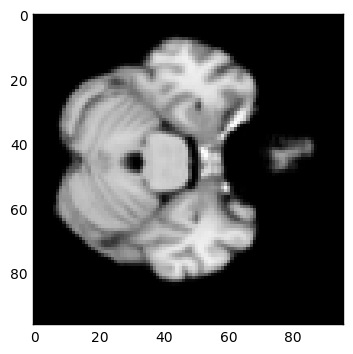

[ 1.  0.  0.]
[ 0.99211532  0.00434646  0.00353827]


In [17]:
# plot images that are highly accurate or innacurate classifications
n = 7517
plt.imshow(vaX[n,0,:,:],cmap=cm.Greys_r,interpolation='none'); plt.show()
print(vaY_labels[n,:])
print(pp[n,:])

In [ ]:
# data augmentation
# for these data: want relatively small rotations, translations, zooms and skews
# mainly meant to overcome 1) intersubject variations in anatomy and 2) intersubject differences in the affine registration to standard space
gen_t = image.ImageDataGenerator(rotation_range=2, height_shift_range=0.02, 
                shear_range=0.05, zoom_range=0.05, width_shift_range=0.02)
gen_t.fit(trX)
adam = Adam(lr=0.0001)
model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(gen_t.flow(trX,trY_labels,batch_size=128),samples_per_epoch=len(trX),nb_epoch=2,validation_data=(vaX,vaY_labels))